In [160]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [161]:
corpus = open("datasets/names.txt").read().splitlines()

In [162]:
corpus[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [163]:
#building the mappings like tokeniser
clean = sorted(set(''.join(corpus)))
stoi = {s:i for i,s in enumerate(clean)}
stoi['.'] = 26
itos = {i:s for s,i in stoi.items()}

In [164]:
#build the dataset
block_size = 5
def build_dataset(current_corpus):
        X,Y = [], []
        context = [26] * block_size
        for word in current_corpus:
            word = list(word) + ['.']
            for ch1 in word:
                current = stoi[ch1]
                Y.append(current)
                X.append(context)
                #print(''.join(itos[i] for i in context), '--->', itos[current])
                context = context[1:] + [current]
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X,Y

In [165]:
X,Y = build_dataset(corpus)

In [166]:
X.shape, Y.shape

(torch.Size([228146, 5]), torch.Size([228146]))

In [167]:
block_size = 5
embedding_size = 6
batch_size = 32
fan_in = embedding_size * block_size
g = torch.Generator().manual_seed(2347243647 + 10)
C = torch.randn((27,embedding_size),generator=g)
w1 = torch.randn((fan_in, 200),generator=g) * 0.01
b1 = torch.randn((200),generator=g) * 0
w2 = torch.randn((200, 27),generator=g) * 0.01
b2 = torch.randn((27),generator=g) * 0


bngain = torch.ones((1, 200))
bnbias = torch.zeros((1, 200))

running_mean = torch.zeros((1, 200))
running_std = torch.ones((1, 200))
momentum = 0.1


parameters = [C, w1, b1, w2, b2]

count = 0
for p in parameters:
    count += p.nelement()
count

11789

In [121]:
counts = logits.exp()      #logits increase to make counts
prob = counts / counts.sum(-1, keepdims=True) #counts normalized
manual_loss = -prob[torch.arange(413),Y].log().mean() #model product for all correct prob.trans

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [413], [228146]

11789

In [168]:
for p in parameters:
    p.requires_grad = True

In [169]:
steps, lossi = [],[]

In [171]:
for i in range(20000):

  #generate a batch
  idx = torch.randint(0, X.shape[0], (batch_size+32,))
  
  #forward pass
  emb = C[X[idx]]
  hpreact = emb.view(-1,fan_in) @ w1 + b1

  #batch norm layer
  bmeani = hpreact.mean(0, keepdim=True)
  bstdi = hpreact.std(0, keepdim=True)

  with torch.no_grad():
    running_mean = (1 - momentum) * running_mean + momentum * bmeani
    running_std = (1 - momentum) * running_std + momentum * bstdi

  hpreact = bngain * (hpreact - bmeani) / bstdi  + bnbias
 


  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  step_loss = f.cross_entropy(logits,Y[idx])



  #backward pass
  for p in parameters:
    p.grad = None
  step_loss.backward()

  #update
  #lr = 0.1 if i < 10000 else 0.01
  lr = 0.001
  steps.append(i)
  lossi.append(step_loss.item())
  for p in parameters:
    p.data += -lr * p.grad
print(step_loss.item())

2.1683168411254883


In [172]:
lossi[-10:]

[2.2160637378692627,
 2.1525299549102783,
 2.2221109867095947,
 2.074035167694092,
 2.1232895851135254,
 2.250047206878662,
 2.003643035888672,
 2.1879348754882812,
 2.042870283126831,
 2.1683168411254883]

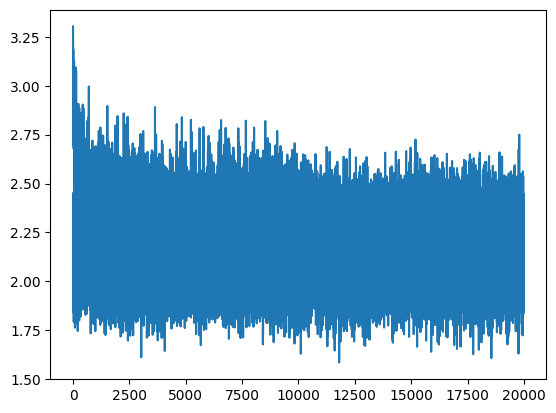

In [158]:
plt.plot(steps, lossi)

In [173]:
# sample from the model
g = torch.Generator().manual_seed(2147447+10)

for _ in range(50):
    out = []
    context = [26] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      hpreact = emb.view(1, -1) @ w1 + b1
      hpreact = bngain * (hpreact - running_mean) / running_std + bnbias
      h = torch.tanh(hpreact)
      logits = h @ w2 + b2
      probs = f.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 26:
        break

    print(''.join(itos[i] for i in out))

pyaleh.
haveir.
imerah.
mirina.
dinora.
plesleah.
jdill.
kiriann.
bridet.
ltpoueslana.
lyyanna.
tryson.
likina.
rxari.
besslea.
kigrianna.
mlyzari.
kree.
hslon.
fuuler.
clrish.
brist.
fylannny.
zxariel.
mleyca.
llyake.
rilee.
lasrot.
brpcccery.
liflos.
rimarion.
bbisan.
bibel.
tirre.
kbesa.
iuera.
kubues.
barly.
xibe.
iristaire.
brimah.
rambracie.
jicea.
gritori.
midrishan.
pbest.
breor.
briesyn.
klayne.
rivuvir.


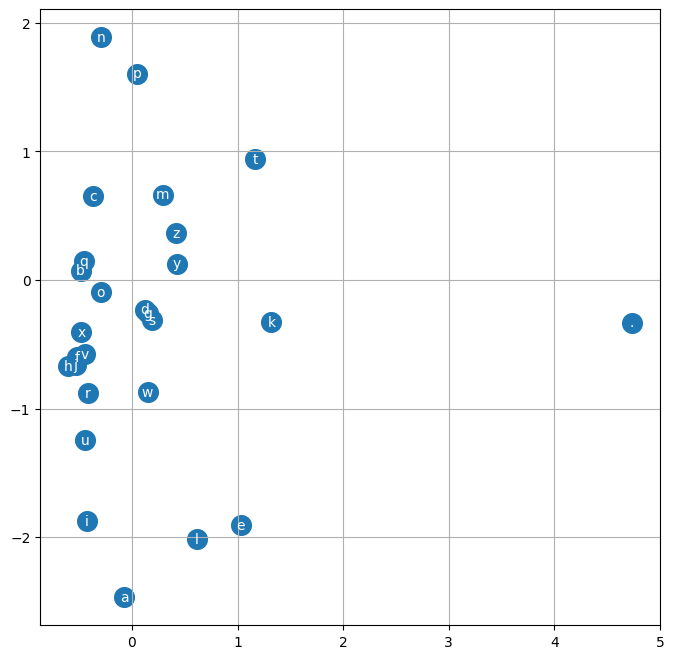

In [63]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')